# Stylized Facts about stock returns

### Empirical properties of asset returns: stylized facts and statistical issues, Rama Cont
http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf


Estudos empíricos mostram que do ponto de vista estatístico, as séries de preços de inúmeros ativos apresentam propriedades comuns, apesar de serem mercados e instrumentos totalmente diferentes. Essas propriedades recorrentes são chamadas de fatos estilizados (stylized facts). 
Os fatos estilizados aparecem ao se identificar o que é comum entre diferentes mercados e ativos. Isso traz generalidade, mas reduz a precisão: são características qualitativas, não específicas o suficiente para distinguir facilmente entre modelos paramétricos. 

In [61]:
import itertools
import datetime as dt

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

import yfinance as yf

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

In [62]:
np.random.seed(42)

today = dt.date.today().strftime('%Y-%m-%d')
start = '2015-01-01'

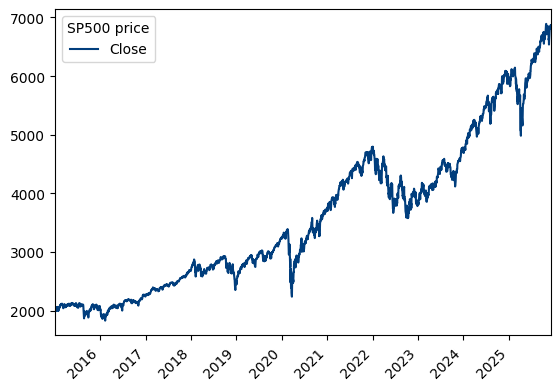

In [63]:
spx_ticker = yf.Ticker("^SPX")
df = spx_ticker.history(start=start, end=today)['Close']
df.index = pd.to_datetime(df.index.date, format='%Y-%m-%d')

# plot

df.plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.legend(title="SP500 price" , fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([df.index[0], df.index[-1]])
plt.show()


In [64]:

# log-returns

daily_return = np.log(df).diff().dropna()
weekly_return = np.log(df.resample('W').last()).diff().dropna()
monthly_return = np.log(df.resample('ME').last()).diff().dropna()

## Stylized Fact 5: Intermittency

**Intermitência** A volatilidade apresenta explosões irregulares: períodos calmos são alternados com períodos de extrema turbulência, em qualquer escala de tempo, i.e., os retornos exibem, em qualquer escala de tempo, um alto grau de variabilidade. Isso é quantificado pela presença de picos irregulares em séries temporais de uma ampla variedade de estimadores de volatilidade.


**EWMA — Exponentially Weighted Moving Average (RiskMetrics)**

O modelo **EWMA** é um método amplamente utilizado no mercado financeiro para estimar a **volatilidade condicional** de retornos. Ele atribui **mais peso aos retornos recentes** e **menos peso aos retornos antigos**, usando um fator de decaimento exponencial.  O EWMA responde rapidamente a picos de volatilidade, é simples e sem parâmetros adicionais.

$$
\sigma_t^2
= (1 - \lambda) r_{t-1}^2
+ \lambda (1 - \lambda) r_{t-2}^2
+ \lambda^2 (1 - \lambda) r_{t-3}^2
+ \cdots 
+ \lambda^{t-1} (1 - \lambda) r_{0}^2
+ \lambda^{t} \sigma_{0}^2.
$$
Ou seja:
- O peso de $ r_{t-k}^2 $ é $ (1 - \lambda)\lambda^{k-1} $,
- Quanto maior $ \lambda $, mais lenta é a perda de memória,
- A série completa forma uma **média móvel exponencial** dos quadrados dos retornos.


Pode ser facilmente calculada, dada uma série de retornos $ r_t$, a variância condicional no tempo $t$ é
$$
\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_{t-1}^2,
$$
A volatilidade é
$$
\sigma_t = \sqrt{\sigma_t^2}.
$$

**Observação sobre parâmetros usuais**

- Para **retornos diários** → \( \lambda = 0.94 \)
- Para **retornos semanais ou mensais** → \( \lambda = 0.97 \)

Esses valores vêm do modelo original do *RiskMetrics*.

In [65]:
# -----------------------------------------------
# EWMA Vol
# -----------------------------------------------
def ewma_vol(ret, lam=0.97):
    vol = np.zeros(len(ret))
    vol[0] = ret.var()   # inicialização
    for t in range(1, len(ret)):
        vol[t] = lam * vol[t-1] + (1-lam) * ret.iloc[t-1]**2
    return pd.Series(np.sqrt(vol), index=ret.index)

# -----------------------------------------------
#  Volatilidade Realizada
# -----------------------------------------------
def realized_vol(r, window=21):
    return r.rolling(window).std()


In [66]:

# vol  para cada frequência
ewma_daily   = ewma_vol(daily_return)
ewma_weekly  = ewma_vol(weekly_return)
ewma_monthly = ewma_vol(monthly_return)

rv_daily   = realized_vol(daily_return,30)
rv_weekly  = realized_vol(weekly_return,8)
rv_monthly = realized_vol(monthly_return,6)
# ---------------------------------------------------------


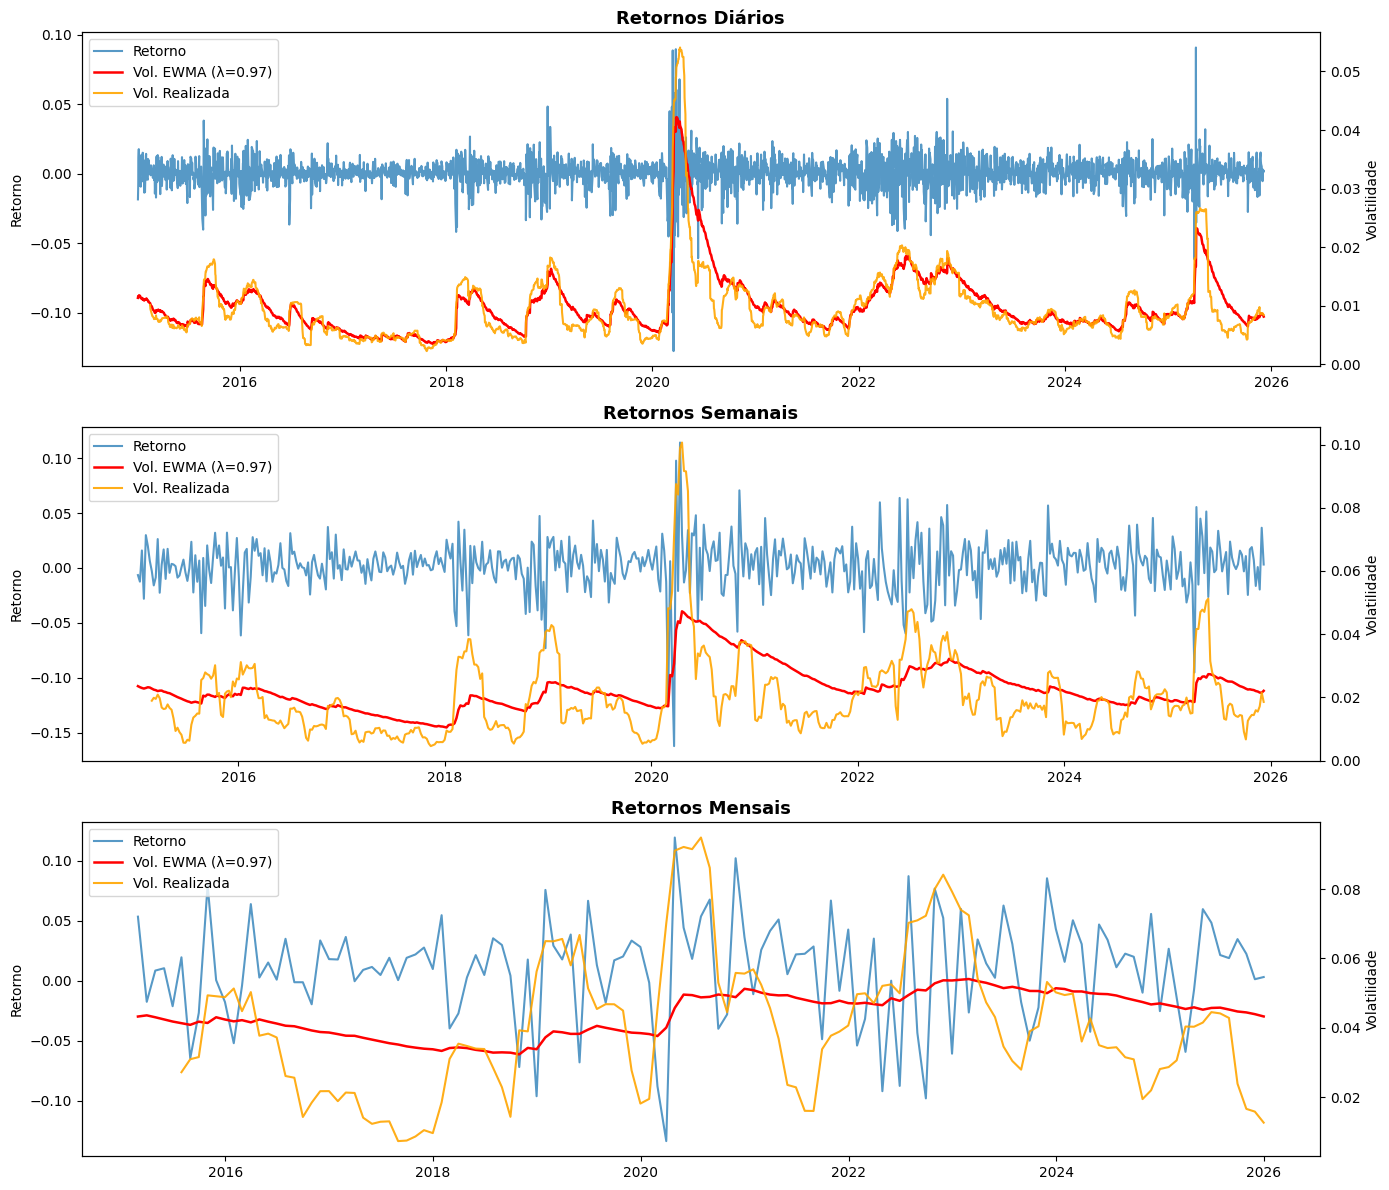

In [67]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

datasets = [
    ("Retornos Diários",  daily_return,   ewma_daily,   rv_daily),
    ("Retornos Semanais", weekly_return,  ewma_weekly,  rv_weekly),
    ("Retornos Mensais",  monthly_return, ewma_monthly, rv_monthly)
]

for ax, (title, returns, ewma, rv) in zip(axes, datasets):

    ax2 = ax.twinx()

    # Retornos
    l1 = ax.plot(returns.index, returns, label="Retorno", alpha=0.75)

    # Vol EWMA e Realizada
    l2 = ax2.plot(ewma.index, ewma, color="red", label="Vol. EWMA (λ=0.97)", linewidth=1.8)
    l3 = ax2.plot(rv.index, rv, color="orange", label="Vol. Realizada", alpha=0.9)

    ax.set_title(title, fontsize=13, fontweight="bold")

    # Legenda combinada
    lines = l1 + l2 + l3
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc="upper left", frameon=True)

    ax.set_ylabel("Retorno")
    ax2.set_ylabel("Volatilidade")

plt.tight_layout()
plt.show()

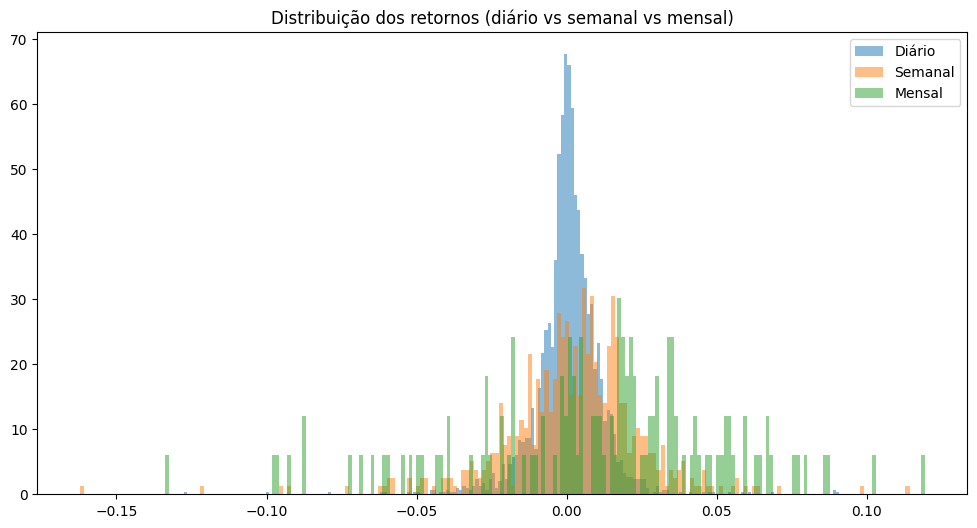

In [68]:

# ---------------------------------------
#  Comparação das distribuições dos retornos
#    — agregational Gaussianity + intermitência
# ---------------------------------------
plt.figure(figsize=(12,6))
plt.hist(daily_return, bins=200, density=True, alpha=0.5, label='Diário')
plt.hist(weekly_return, bins=200, density=True, alpha=0.5, label='Semanal')
plt.hist(monthly_return, bins=200, density=True, alpha=0.5, label='Mensal')
plt.title('Distribuição dos retornos (diário vs semanal vs mensal)')
plt.legend()
plt.show()




Detecçã dos  regimes de volatilidade via Markov Switching: 
- cada regime ter sua própria variância;
- transições probabilísticas entre regimes
- estimar P(regime=1 | dados) para cada dia

Assim, o modelo aprende automaticamente:
- períodos de crise (alta vol)
- períodos tranquilos (baixa vol)
- datas aproximadas das transições de regime


✔ O que está sendo modelado aqui?
O modelo é aplicado sobre retornos logarítmicos (que têm média ≈ 0)

✔ O que o MS detecta aqui?
Ele detecta regimes de retorno, não de volatilidade:

Regime 1 → retorno médio baixo, volatilidade baixa/alta (dependendo do fit)

Regime 2 → retorno médio diferente, variância diferente

✔ Mas na prática…
Como os retornos são muito próximos de zero, um MS direto em rₜ normalmente identifica apenas:

regimes de variância diferente (volatilidade implícita)

às vezes dois regimes idênticos em média

Ou seja: é mais difícil interpretar como regimes econômicos.

/home/yair/bin/pythorix/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  Close   No. Observations:                 2748
Model:               MarkovRegression   Log Likelihood                9023.000
Date:                Mon, 08 Dec 2025   AIC                         -18034.001
Time:                        12:03:43   BIC                         -17998.489
Sample:                             0   HQIC                        -18021.170
                               - 2748                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      7.092      0.000       0.001       0.001
sigma2      3.836e-05   2.17e-06     17.717      0.0

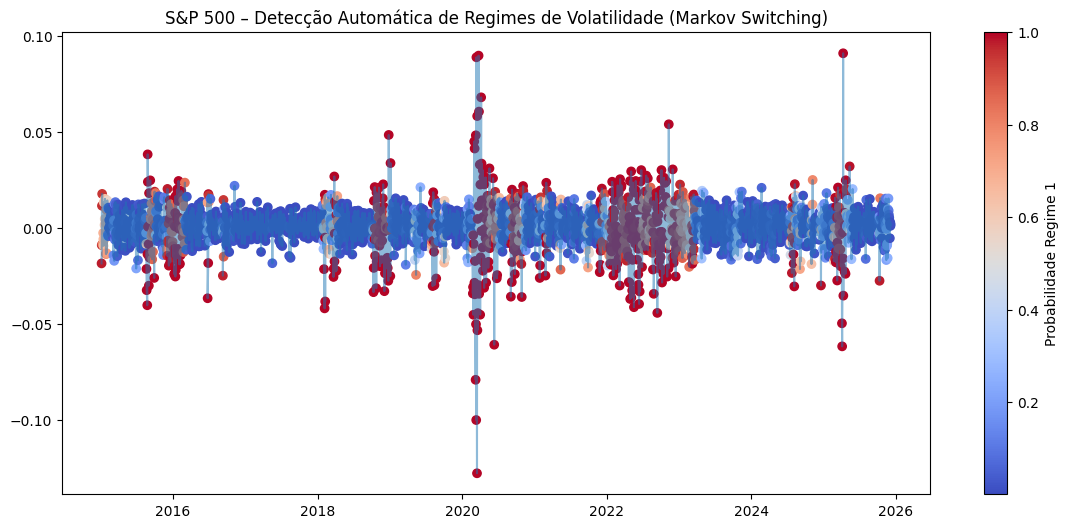

Desvio-padrão regime 0 (low vol): 0.006193925689821055
Desvio-padrão regime 1 (high vol): 0.01838178382074284


In [69]:
# Vamos usar retornos como série unidimensional
r = daily_return.squeeze()

# Modelo Markov Switching com 2 regimes
# switching_variance=True faz a variância mudar entre regimes
mod = sm.tsa.MarkovRegression(
    r,
    k_regimes=2, order=1,
    trend='c',
    switching_variance=True
)

res = mod.fit(em_iter=10, maxiter=200)
print(res.summary())


#  Probabilidade filtrada do regime 1 (interpretado normalmente como alta volatilidade)
prob_regime1 = res.filtered_marginal_probabilities[1]
prob_regime0 = res.filtered_marginal_probabilities[0]

# Probabilidade suavizada (usa toda a amostra)
smooth_regime1 = res.smoothed_marginal_probabilities[1]

plt.figure(figsize=(14,6))

plt.plot(r.index, r, label='Retornos', alpha=0.5)
plt.scatter(
    r.index, r,
    c=smooth_regime1, cmap='coolwarm',
    label='Probabilidade Regime 1 (alta volatilidade)'
)
plt.colorbar(label='Probabilidade Regime 1')
plt.title("S&P 500 – Detecção Automática de Regimes de Volatilidade (Markov Switching)")
plt.show()

print("Desvio-padrão regime 0 (low vol):", np.sqrt(res.params['sigma2[0]']))
print("Desvio-padrão regime 1 (high vol):", np.sqrt(res.params['sigma2[1]']))


Detecção automática de regimes usando Markov Switching (MS-AR)
O pacote statsmodels possui Markov Switching para modelos AR.
O mais comum para volatilidade é usar MS-AR sobre |returns| ou returns².


o retorno absoluto é uma proxy direta da volatilidade diária.

✔ O que o MS detecta aqui?
Ele encontra regimes de volatilidade:

Regime 1 → dias tranquilos (volatilidade baixa)

Regime 2 → dias turbulentos (volatilidade alta)

Esse é o uso mais comum em detecção de regimes de risco/volatilidade.

/home/yair/bin/pythorix/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  Close   No. Observations:                 2748
Model:               MarkovRegression   Log Likelihood               10188.598
Date:                Mon, 08 Dec 2025   AIC                         -20365.197
Time:                        12:03:44   BIC                         -20329.685
Sample:                             0   HQIC                        -20352.366
                               - 2748                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.000     34.416      0.000       0.004       0.005
sigma2      1.385e-05   9.46e-07     14.639      0.0

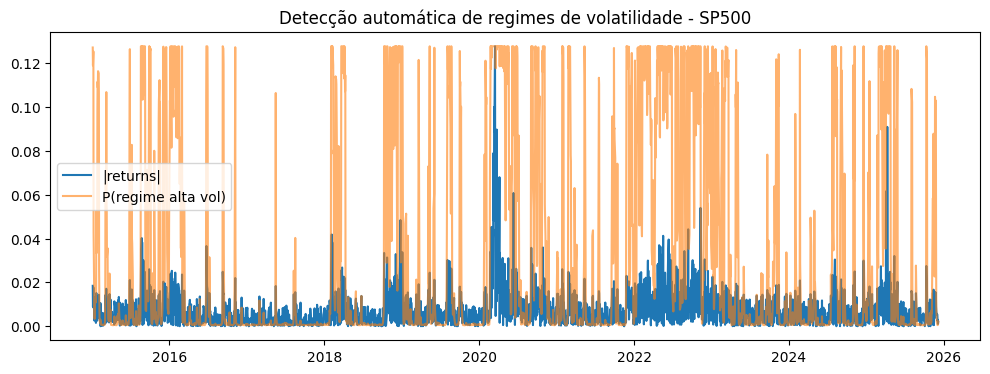

In [70]:
r = daily_return.copy()
abs_r = np.abs(r)

# --- Modelo MS-AR(0) nos retornos absolutos (volatilidade proxy)
mod = MarkovRegression(abs_r, k_regimes=2, trend='c', switching_variance=True)
res = mod.fit()

print(res.summary())

# --- Probabilidade filtrada de estar no regime 1 (alta vol)
probs = res.smoothed_marginal_probabilities[1]


plt.figure(figsize=(12,4))
plt.plot(abs_r.index, abs_r, label="|returns|")
plt.plot(probs.index, probs * abs_r.max(), label="P(regime alta vol)", alpha=0.6)
plt.legend()
plt.title("Detecção automática de regimes de volatilidade - SP500")
plt.show()

GARCH retira parte da clusterização de volatilidade


Iteration:     10,   Func. Count:     78,   Neg. LLF: 3454.579705085649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3454.579597616884
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 13
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3454.58
Distribution:      Standardized Student's t   AIC:                           6919.16
Method:                  Maximum Likelihood   BIC:                           6948.75
                                              No. Observations:                 2748
Date:                      Mon, Dec 08 2025   Df Residuals:                     2747
Time:                              12:0

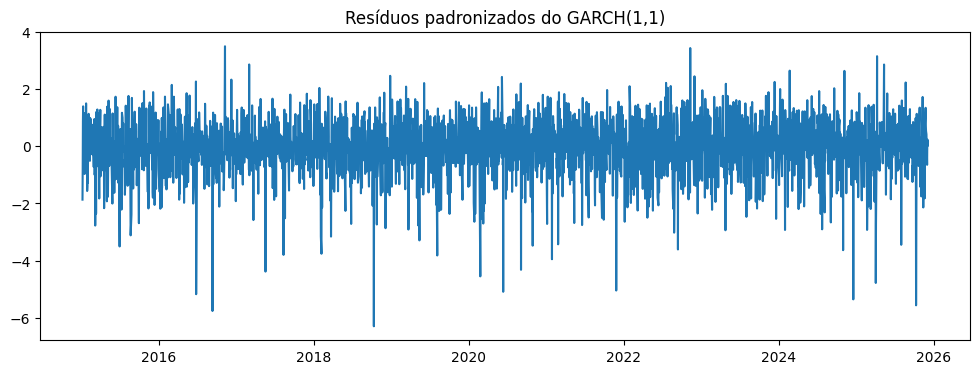

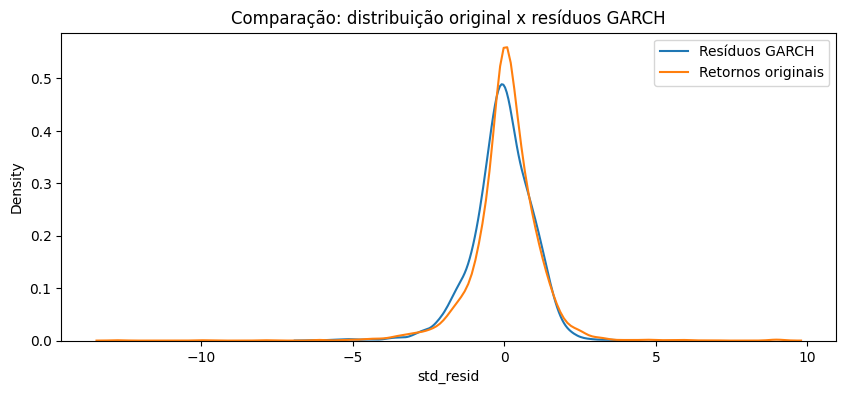

In [71]:

# --- Retornos em porcentagem
r = daily_return * 100  

# --- GARCH(1,1)
garch = arch_model(r, vol='GARCH', p=1, q=1, dist='t')
res_garch = garch.fit(update_freq=10)
print(res_garch.summary())

# --- Resíduos padronizados
std_resid = res_garch.std_resid

plt.figure(figsize=(12,4))
plt.plot(std_resid)
plt.title("Resíduos padronizados do GARCH(1,1)")
plt.show()

plt.figure(figsize=(10,4))
sns.kdeplot(std_resid, label="Resíduos GARCH")
sns.kdeplot(r, label="Retornos originais")
plt.title("Comparação: distribuição original x resíduos GARCH")
plt.legend()
plt.show()


A seguir está um exemplo completo de detecção de regimes de volatilidade usando filtro de Kalman + Mudança de Regime via pykalman.

A ideia é modelar a volatilidade latente como um processo que muda entre dois regimes (alta e baixa volatilidade), fazendo um state-switching manual usando o pykalman.

Ideia do modelo
Estimar a série de volatilidade diária usando o quadrado dos retornos ou EWMA.

Assumir que essa volatilidade latente segue um processo linear gaussiano, mas que alterna entre regime 1 (baixa vol) e regime 2 (alta vol).

Ajustar dois filtros de Kalman diferentes, um para cada regime.

Usar o algoritmo de Hamilton–Kim (similar ao Markov switching) para inferir a probabilidade de cada regime dados os dados observados.

Obs.: O pykalman não possui direct Markov switching, mas podemos implementar um esquema de likelihood weighting simples.

regime 1 = baixa volatilidade

regime 2 = alta volatilidade

Atualiza as probabilidades de cada regime a cada passo.



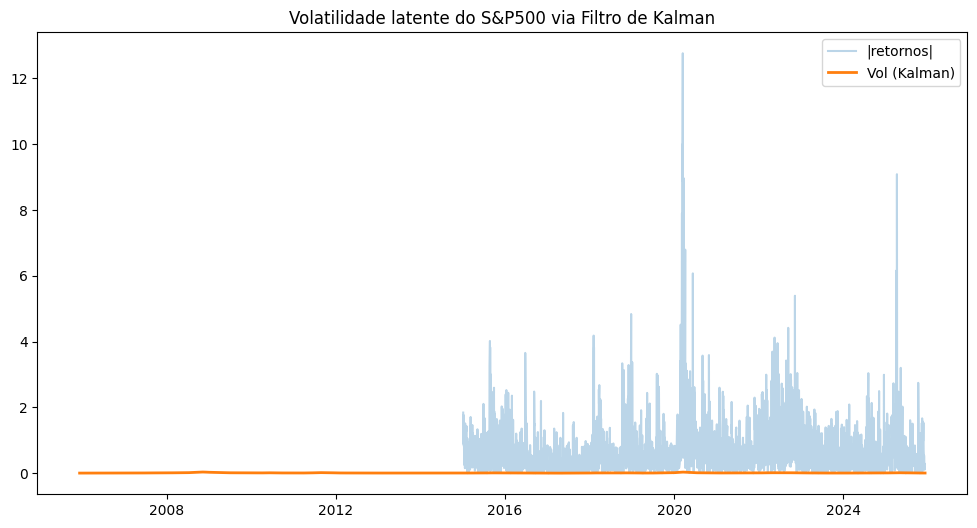

In [72]:

from pykalman import KalmanFilter
# ---------------------------------------------------------
# 1. Dados do S&P500
# ---------------------------------------------------------
df2 = spx_ticker.history(period="20y")
ret = np.log(df2['Close']).diff().dropna()

# volatilidade proxy
vol_proxy = (ret**2)

kf = KalmanFilter(
    transition_matrices = np.array([[1]]),      # var_t = 1 * var_{t-1} + noise
    observation_matrices = np.array([[1]]),     # obs = var_t + noise
    initial_state_mean = vol_proxy.iloc[0],
    initial_state_covariance = 1.0,
    transition_covariance = 1e-7,               # suavidade temporal
    observation_covariance = 1e-4               # ruído da observação
)

# Filtro e suavização
state_means, state_covs = kf.smooth(vol_proxy.values)

# ----------------------------------------------------------
# 3. Organizar resultados com o mesmo índice
# ----------------------------------------------------------
filtered_var = pd.Series(state_means.flatten(), index=vol_proxy.index)
filtered_vol = np.sqrt(filtered_var)

# ----------------------------------------------------------
# 4. Plot
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(r.index, np.abs(r), alpha=0.3, label="|retornos|")
plt.plot(filtered_vol.index, filtered_vol, linewidth=2, label="Vol (Kalman)")
plt.legend()
plt.title("Volatilidade latente do S&P500 via Filtro de Kalman")
plt.show()

## Stylized Fact 1: Absence of autocorrelations

(linear) autocorrelations
of asset returns are often insignificant, except for very
small intraday time scales ( 20 minutes) for which
microstructure effects come into play

$$\rho_k = \mbox{Corr}(R_{t_i}, R_{t_{i+k}})$$

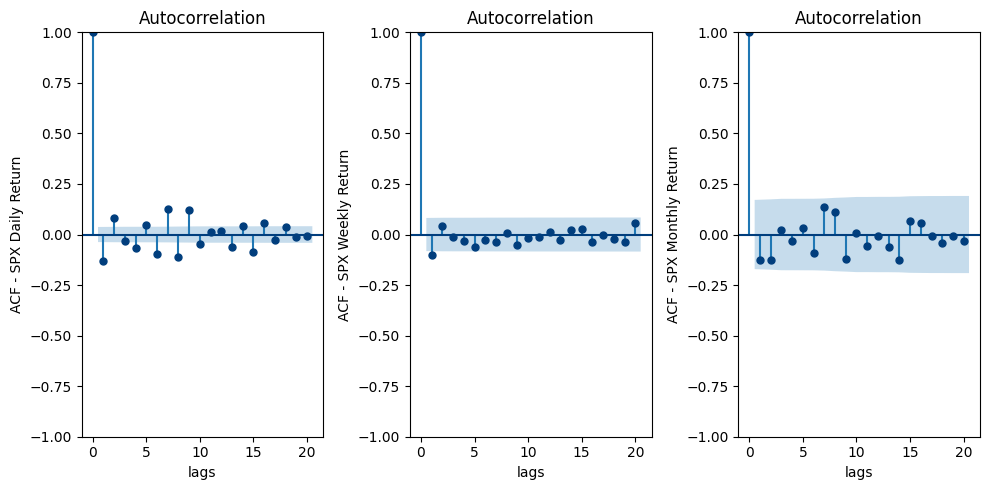

In [73]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(daily_return, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(weekly_return, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_return, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Return')

plt.tight_layout()


## Stylized Facts 2, 3 and 4: Heavy tails, Gain/loss asymmetry, Aggregational Gaussianity

- the (unconditional) distribution of returns
seems to display a power-law or Pareto-like tail, with
a tail index which is finite, higher than two and less
than five for most data sets studied. In particular this
excludes stable laws with infinite variance and the normal
distribution. However the precise form of the tails is
difficult to determine.

- one observes large drawdowns in
stock prices and stock index values but not equally large
upward movements (This property is not true for exchange rates where there is a higher symmetry
in up/down moves.)

- as one increases the
time scale $\Delta t$ over which returns are calculated,
their distribution looks more and more like a normal
distribution. In particular, the shape of the distribution
is not the same at different time scales.

$\displaystyle \mu = \mathbb{E}[X]$

$\displaystyle \sigma^2 = \mathbb{E}\left[(X - \mu)^2 \right]$

$\displaystyle \text{Skew}(X) = \mathbb{E}\left[\left(\frac{X - \mu}{\sigma}\right)^3 \right]$

$\displaystyle \text{Kurt}(X) = \mathbb{E}\left[\left(\frac{X - \mu}{\sigma}\right)^4 \right]$

In [74]:
print('Skewness Daily Return: ', skew(daily_return, axis=0, bias=True))
print('Skewness Weekly Return: ', skew(weekly_return, axis=0, bias=True))
print('Skewness Monthly Return: ', skew(monthly_return, axis=0, bias=True))

Skewness Daily Return:  -0.6551407012658736
Skewness Weekly Return:  -0.9153546555671899
Skewness Monthly Return:  -0.5734299073943222


In [75]:
print('Kurtosis Daily Return: ', kurtosis(daily_return, axis=0, bias=True)+3)
print('Kurtosis Weekly Return: ', kurtosis(weekly_return, axis=0, bias=True)+3)
print('Kurtosis Monthly Return: ', kurtosis(monthly_return, axis=0, bias=True)+3)

Kurtosis Daily Return:  18.84350402165127
Kurtosis Weekly Return:  10.13411400244431
Kurtosis Monthly Return:  3.7058632228836017


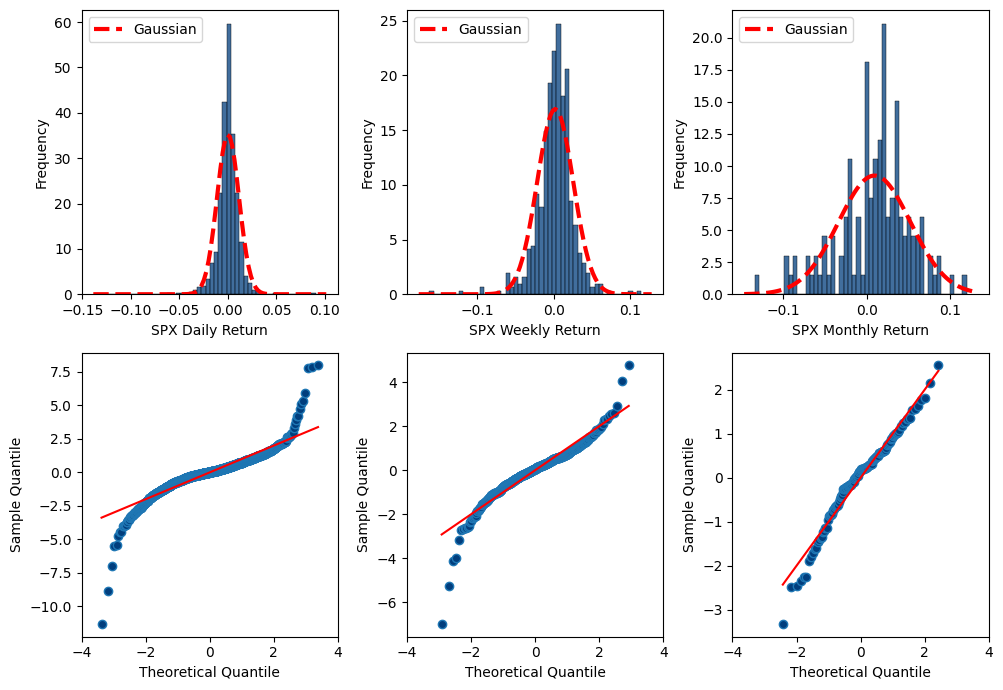

In [76]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(231)
sns.histplot(daily_return, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(daily_return), np.std(daily_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Daily Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(234)
qq = qqplot(daily_return, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(232)
sns.histplot(weekly_return, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(weekly_return), np.std(weekly_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Weekly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(235)
qq = qqplot(weekly_return, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(233)
sns.histplot(monthly_return, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(monthly_return), np.std(monthly_return))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Monthly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(236)
qq = qqplot(monthly_return, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

plt.tight_layout()

# Advanced Stylized Facts

## Stylized Fact 6: Volatility clustering

different measures of volatility
display a positive autocorrelation over several days, which
quantifies the fact that high-volatility events tend to cluster
in time.

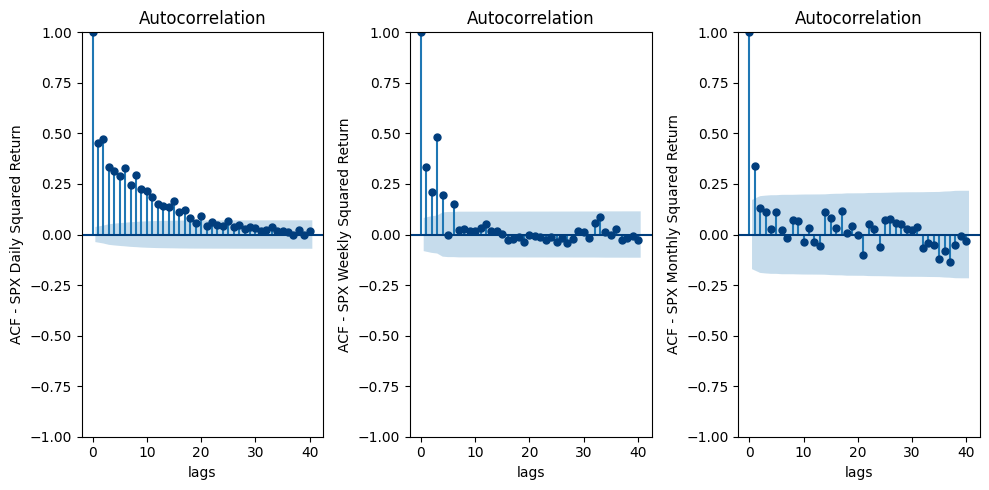

In [77]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(daily_return**2, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Squared Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(weekly_return**2, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Squared Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_return**2, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Squared Return')

plt.tight_layout()

## Stylized Fact 8:  Slow decay of autocorrelation in absolute returns:

the
autocorrelation function of absolute returns decays slowly
as a function of the time lag, roughly as a power law with
an exponent β ∈ [0.2, 0.4]. This is sometimes interpreted
as a sign of long-range dependence.

$$c_k = \mbox{Corr}(|R_{t_i}|, |R_{t_{i+k}}|) \sim \frac{a}{k^\beta}$$

In [78]:
def power(x, a, b):
    return a / np.power(x, b)

initial_guess = [1, 1]
lags = np.arange(1, 41)
daily_abs_acf = sm.tsa.stattools.acf(np.abs(daily_return), nlags=lags[-1]-1)
weekly_abs_acf = sm.tsa.stattools.acf(np.abs(weekly_return), nlags=lags[-1]-1)
monthly_abs_acf = sm.tsa.stattools.acf(np.abs(monthly_return), nlags=lags[-1]-1)

popt_daily, pcov_daily = curve_fit(power, lags[1:], daily_abs_acf[1:], p0=initial_guess, maxfev=5000)
popt_weekly, pcov_weekly = curve_fit(power, lags[1:], weekly_abs_acf[1:], p0=initial_guess, maxfev=5000)
popt_monthly, pcov_monthly = curve_fit(power, lags[1:], monthly_abs_acf[1:], p0=initial_guess, maxfev=5000)

In [79]:
print('Power law for Daily Return: ', popt_daily)
print('Power law for Weekly Return: ', popt_weekly)
print('Power law for Monthly Return: ', popt_monthly)

Power law for Daily Return:  [0.67768626 0.46424795]
Power law for Weekly Return:  [0.75509277 0.97341105]
Power law for Monthly Return:  [0.47868838 0.95544578]


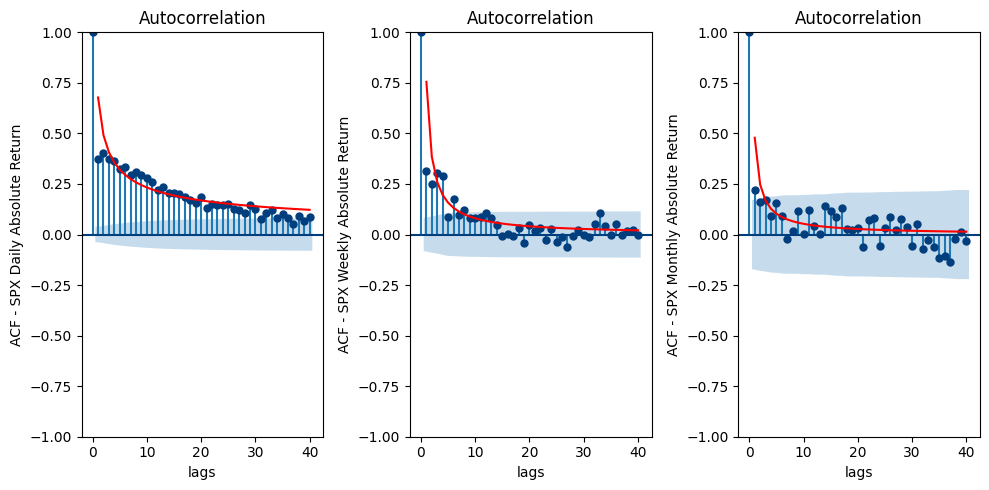

In [80]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(np.abs(daily_return), lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
ax.plot(lags, power(lags, *popt_daily), 'r-')
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Absolute Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(np.abs(weekly_return), lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
ax.plot(lags, power(lags, *popt_weekly), 'r-')
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Absolute Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(np.abs(monthly_return), lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
ax.plot(lags, power(lags, *popt_monthly), 'r-')
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Absolute Return')

plt.tight_layout()

## Stylized Fact 7:  Conditional heavy tails

even after correcting returns for
volatility clustering (e.g. via GARCH-type models), the
residual time series still exhibit heavy tails. However, the
tails are less heavy than in the unconditional distribution
of returns.

In [81]:
!pip3 install arch
from arch import arch_model

In [82]:
garch = arch_model(100*daily_return, vol='GARCH', p=1, q=1, dist='gaussian')
daily_res_fit = garch.fit(update_freq=0, disp="off")
daily_std_resid = pd.Series(daily_res_fit.resid / daily_res_fit.conditional_volatility)

garch = arch_model(100*weekly_return, vol='GARCH', p=1, q=1, dist='gaussian')
weekly_res_fit = garch.fit(update_freq=0, disp="off")
weekly_std_resid = pd.Series(weekly_res_fit.resid / weekly_res_fit.conditional_volatility)

garch = arch_model(100*monthly_return, vol='GARCH', p=1, q=1, dist='gaussian')
monthly_res_fit = garch.fit(update_freq=0, disp="off")
monthly_std_resid = pd.Series(monthly_res_fit.resid / monthly_res_fit.conditional_volatility)

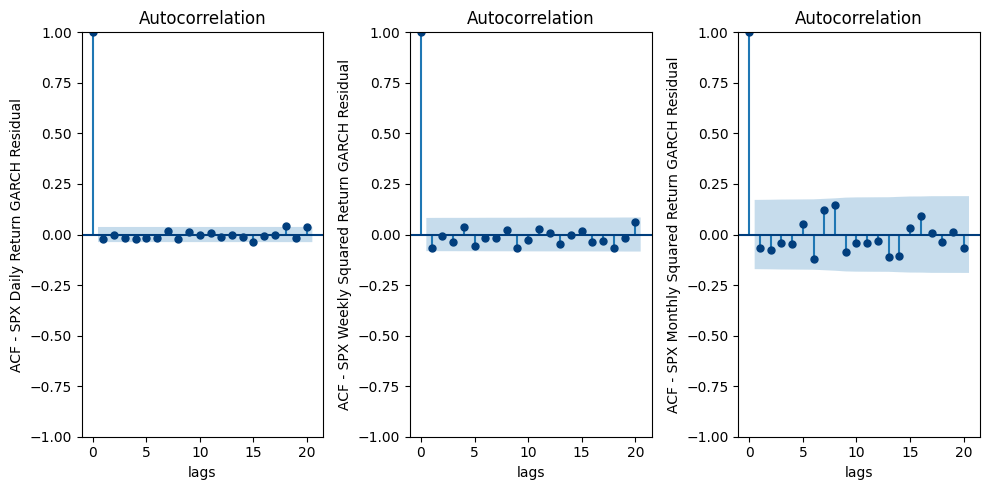

In [83]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(daily_std_resid, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Return GARCH Residual')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(weekly_std_resid, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Squared Return GARCH Residual')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_std_resid, lags=20, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Squared Return GARCH Residual')

plt.tight_layout()

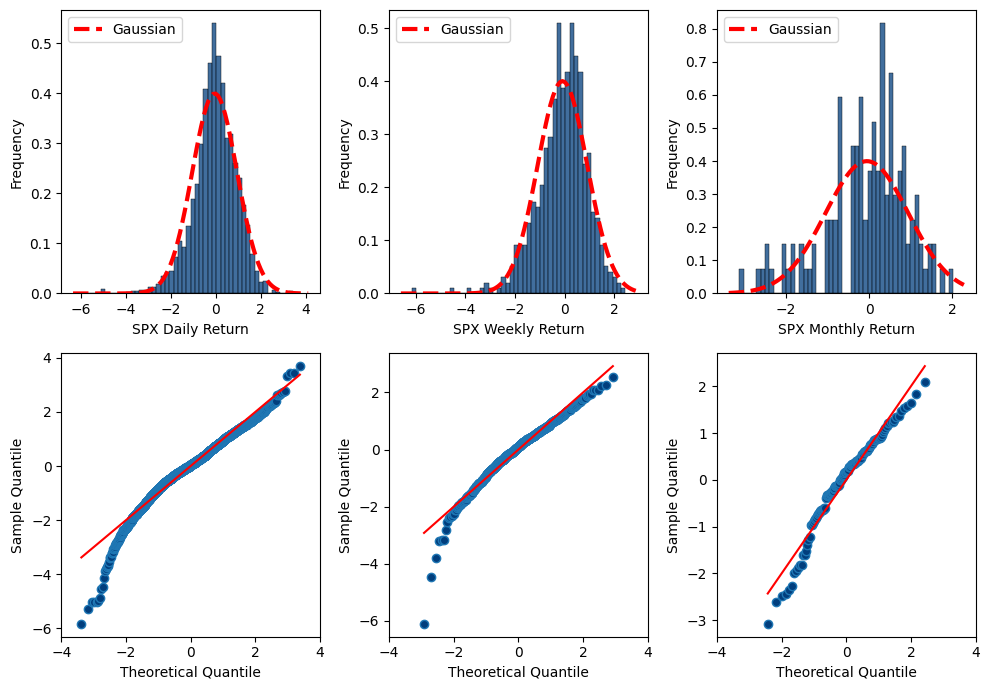

In [84]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(231)
sns.histplot(daily_std_resid, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(daily_std_resid), np.std(daily_std_resid))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Daily Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(234)
qq = qqplot(daily_std_resid, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(232)
sns.histplot(weekly_std_resid, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(weekly_std_resid), np.std(weekly_std_resid))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Weekly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(235)
qq = qqplot(weekly_std_resid, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

ax = fig.add_subplot(233)
sns.histplot(monthly_std_resid, bins=50, color=color_dark_blue, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(monthly_std_resid), np.std(monthly_std_resid))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel('SPX Monthly Return')
plt.ylabel('Frequency')
plt.legend()

ax = fig.add_subplot(236)
qq = qqplot(monthly_std_resid, line='s', ax=ax, markerfacecolor=color_dark_blue, fit=True)
plt.xlabel('Theoretical Quantile')
plt.ylabel('Sample Quantile')
plt.xlim([-4,4]);

plt.tight_layout()

## Stylized fact 9: Leverage effect

most measures of volatility of an asset
are negatively correlated with the returns of that asset. "The theory claims that a price drop in a certain stock
will decrease the value of the firm’s equity, hence increase the leverage-ratio
since the value of the debt will remain the same. The increased leverage-ratio
will, in turn, impose higher risk on the equity and the stock will be more volatile
during next period."

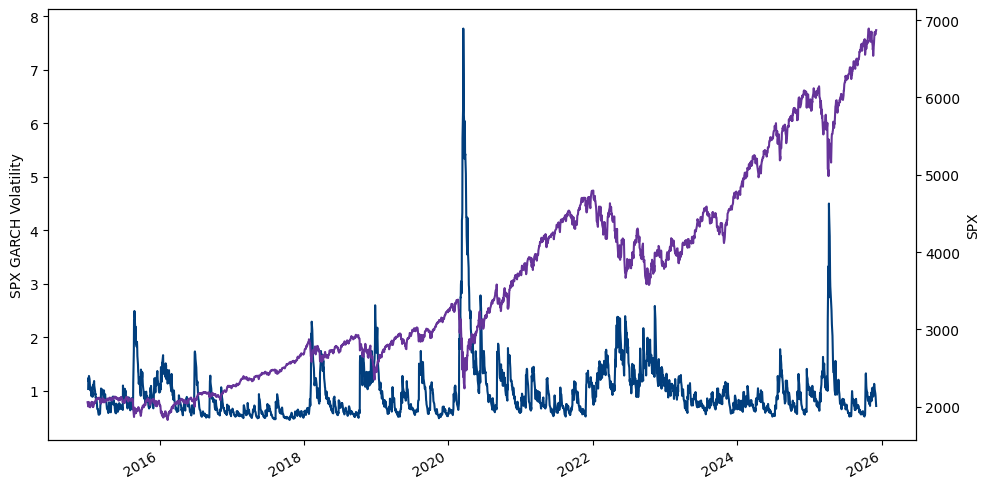

In [85]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
daily_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.ylabel('SPX GARCH Volatility')
df.plot(color=purple, linestyle=color_line[0][0], secondary_y=True)
plt.ylabel('SPX')
plt.xlabel('Time')

# ax = fig.add_subplot(312)
# weekly_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
# plt.ylabel('SPX Weekly Return Volatility')
# plt.xlabel('Time')

# ax = fig.add_subplot(313)
# monthly_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
# plt.ylabel('SPX Monthly Return Volatility')
# plt.xlabel('Time')

plt.tight_layout()

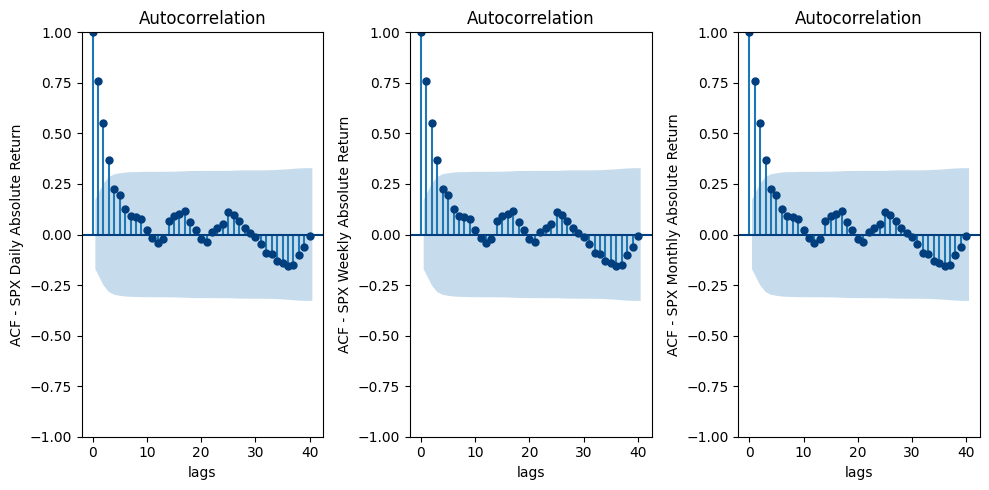

In [86]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(monthly_res_fit.conditional_volatility, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Daily Absolute Return')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(monthly_res_fit.conditional_volatility, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Weekly Absolute Return')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(monthly_res_fit.conditional_volatility, lags=40, ax=ax, alpha=0.05, color=color_dark_blue)
plt.xlabel('lags')
plt.ylabel('ACF - SPX Monthly Absolute Return')

plt.tight_layout()

### Comparing with VIX

In [87]:
vix_ticker = yf.Ticker("^VIX")
vix_data = vix_ticker.history(start=df.index[0], end=df.index[-1])['Close']

In [88]:
df = df.iloc[:-1]
vix_data.index = pd.to_datetime(vix_data.index.date, format='%Y-%m-%d')
vix_data = vix_data[df.index]

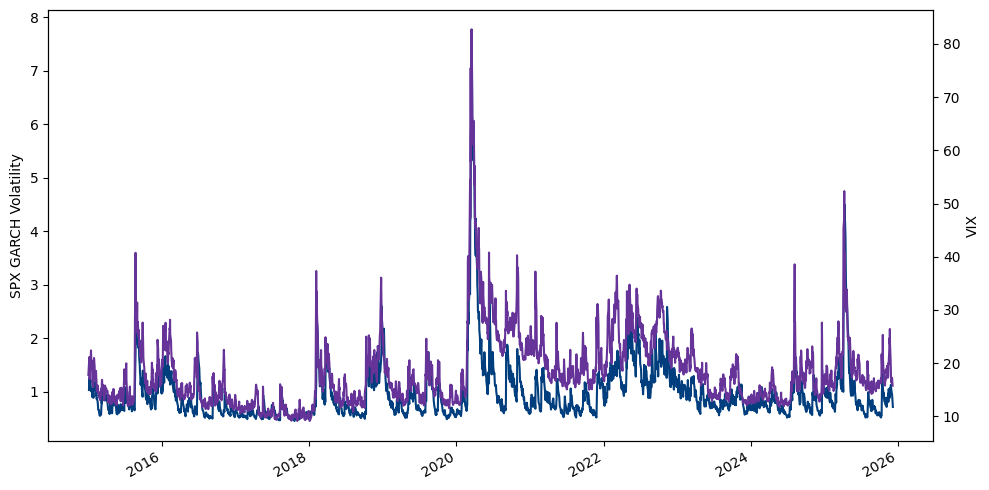

In [89]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
daily_res_fit.conditional_volatility.plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.ylabel('SPX GARCH Volatility')
vix_data.plot(color=purple, linestyle=color_line[0][0], secondary_y=True)
plt.ylabel('VIX')
plt.xlabel('Time')

plt.tight_layout()

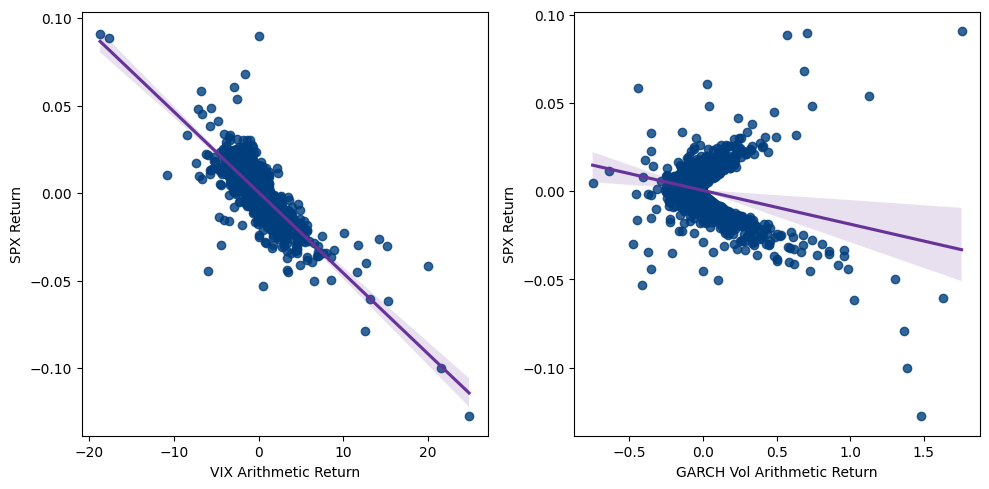

In [90]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
sns.regplot(x=vix_data.diff().dropna(), y=daily_return.iloc[:-1], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('VIX Arithmetic Return')

ax = fig.add_subplot(122)
sns.regplot(x=daily_res_fit.conditional_volatility.diff().dropna(), y=daily_return.iloc[:-1], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('GARCH Vol Arithmetic Return')

plt.tight_layout()

However this effect is asymmetric, in general the correlation is negligible between $\Delta \log(S_t)$ and $\sigma_{t+1}$

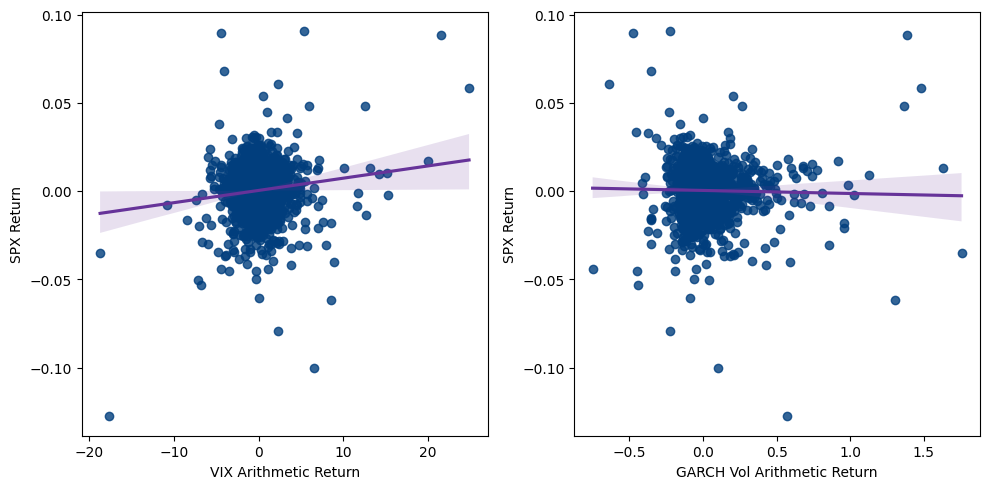

In [91]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
sns.regplot(x=vix_data.diff().dropna(), y=daily_return.iloc[1:], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('VIX Arithmetic Return')

ax = fig.add_subplot(122)
sns.regplot(x=daily_res_fit.conditional_volatility.diff().dropna(), y=daily_return.iloc[1:], color=color_dark_blue, line_kws=dict(color=purple))
plt.ylabel('SPX Return')
plt.xlabel('GARCH Vol Arithmetic Return')

plt.tight_layout()

# Value at Risk Using GARCH

Gaussian noise - Number of 5% exceedance: 1.86%


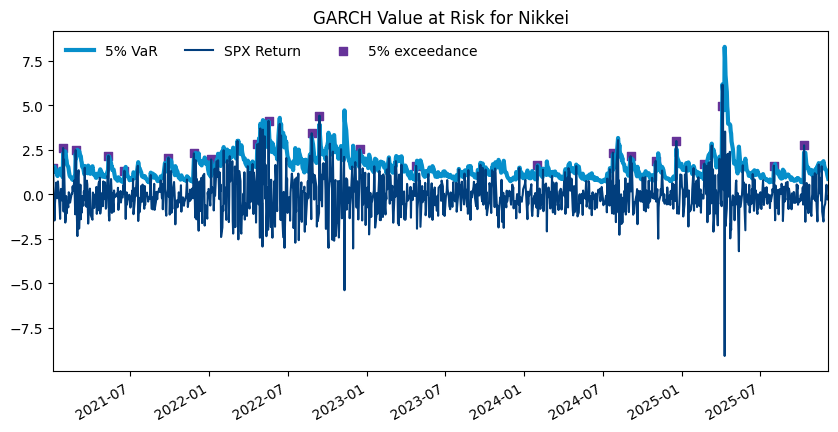

In [92]:
am = arch_model(100*daily_return, vol="Garch", p=1, q=1, dist='gaussian')
res = am.fit(disp="off", last_obs=dt.datetime(2020,12,31))

forecasts = res.forecast(start=dt.datetime(2021,1,1), reindex=False)
cond_mean = forecasts.mean["2021":]
cond_var = forecasts.variance["2021":]
q = am.distribution.ppf([0.05])#, res.params[-1:])

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q
value_at_risk = pd.DataFrame(value_at_risk, columns=["5% VaR"], index=cond_var.index)


ax = value_at_risk.plot(figsize=(10,5),legend=False,color=color_light_blue)

rets = 100*daily_return["2021":].copy()
rets.name = "SPX Return"
(-rets).plot(color=color_dark_blue)

for line in ax.get_lines():
    if line.get_label() == "5% VaR":
        line.set_linewidth(3)

c = []
ret_index_var = []
ret_var = []

five = 0

for idx in value_at_risk.index:
    if rets[idx] <= -value_at_risk.loc[idx, "5% VaR"]:
        five = five + 1
        ret_index_var.append(idx)
        ret_var.append(-rets.loc[idx])

ax.scatter(
    ret_index_var,
    ret_var,
    marker="s",
    c=[purple],
    label="5% exceedance",
)

ax.set_title("GARCH Value at Risk for Nikkei")
leg = ax.legend(frameon=False, ncol=3)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

print("Gaussian noise - Number of 5% exceedance: {:.2f}%".format(100*five/len(value_at_risk.index)))

StudentsT noise - Number of 5% exceedance: 3.55%


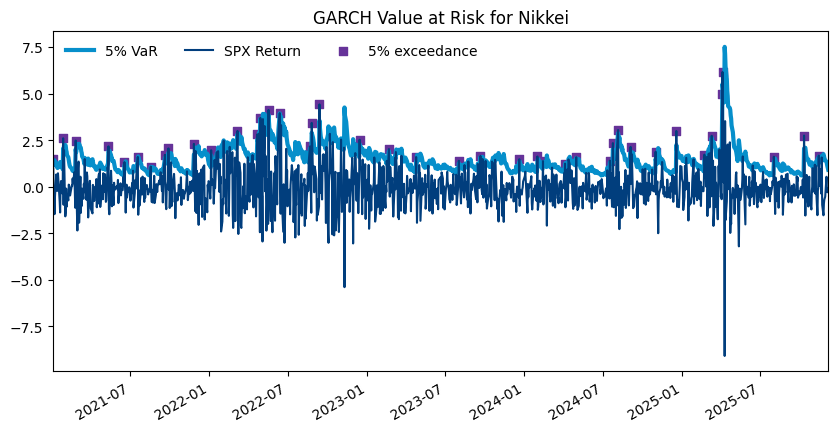

In [93]:
am = arch_model(100*daily_return, vol="Garch", p=1, q=1, dist='StudentsT')
res = am.fit(disp="off", last_obs=dt.datetime(2020,12,31))

forecasts = res.forecast(start=dt.datetime(2021,1,1), reindex=False)
cond_mean = forecasts.mean["2021":]
cond_var = forecasts.variance["2021":]
q = am.distribution.ppf([0.05], res.params[-1:])

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q
value_at_risk = pd.DataFrame(value_at_risk, columns=["5% VaR"], index=cond_var.index)

ax = value_at_risk.plot(figsize=(10,5),legend=False,color=color_light_blue)

rets = 100*daily_return["2021":].copy()
rets.name = "SPX Return"
(-rets).plot(color=color_dark_blue)

for line in ax.get_lines():
    if line.get_label() == "5% VaR":
        line.set_linewidth(3)

c = []
ret_index_var = []
ret_var = []

five = 0

for idx in value_at_risk.index:
    if rets[idx] <= -value_at_risk.loc[idx, "5% VaR"]:
        five = five + 1
        ret_index_var.append(idx)
        ret_var.append(-rets.loc[idx])

ax.scatter(
    ret_index_var,
    ret_var,
    marker="s",
    c=[purple],
    label="5% exceedance",
)

ax.set_title("GARCH Value at Risk for Nikkei")
leg = ax.legend(frameon=False, ncol=3)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

print("StudentsT noise - Number of 5% exceedance: {:.2f}%".format(100*five/len(value_at_risk.index)))